In [8]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.feature import hog
from sklearn.utils import shuffle
import os
from sklearn.model_selection import train_test_split




Part a
_________________________________________________________________________________________________________________________________

Models we use: XGBoost and Neural Network.

In [9]:
input_folder = '../dataset' 
# Input folder that must contain 2 folder, one with masked face images and another non-masked
# Here we assume that name of the 2 sub-directories are 'with_mask' and 'without_mask'

For each image we create a feature vector that reflects texture, Histogram of Gradients (HoG), Scale-invaiant fetaures, etc.

In [11]:
# Resize all images to a fixed size
IMAGE_SIZE = (64, 64)  # Ensures consistent feature vector length

def extract_texture_features(image, num_bins=32):
    """Extracts grayscale histogram-based texture features."""
    image = cv2.resize(image, IMAGE_SIZE)  # Ensure fixed size
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [num_bins], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_hog_features(image):
    """Extracts HOG features with a fixed-length descriptor."""
    image = cv2.resize(image, IMAGE_SIZE)  # Ensure fixed size
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    features = hog(
        gray, 
        orientations=9, 
        pixels_per_cell=(8, 8), 
        cells_per_block=(2, 2), 
        block_norm='L2-Hys'
    )
    
    return features

def extract_shape_features(image, num_bins=32):
    """Extracts edge-based shape features using Canny and histogram."""
    image = cv2.resize(image, IMAGE_SIZE)  # Ensure fixed size
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    
    edge_hist = cv2.calcHist([edges], [0], None, [num_bins], [0, 256])
    edge_hist = cv2.normalize(edge_hist, edge_hist).flatten()
    return edge_hist

def extract_color_features(image):
    """Extracts color histogram features in the HSV space."""
    image = cv2.resize(image, IMAGE_SIZE)  # Ensure fixed size
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_keypoint_features(image, max_features=128):
    """Extracts ORB keypoint-based features with a fixed length."""
    image = cv2.resize(image, IMAGE_SIZE)  # Ensure fixed size
    orb = cv2.ORB_create()
    kp, des = orb.detectAndCompute(image, None)

    if des is None:
        return np.zeros(max_features)  # No keypoints, return zero vector

    des = des.flatten()  # Flatten descriptor array
    return des[:max_features] if len(des) >= max_features else np.pad(des, (0, max_features - len(des)))

def extract_features(image):
    """Combines all feature extractions into a single feature vector."""
    texture_features = extract_texture_features(image)
    shape_features = extract_shape_features(image)
    color_features = extract_color_features(image)
    hog_features = extract_hog_features(image)
    keypoint_features = extract_keypoint_features(image)

    return np.hstack((texture_features, shape_features, color_features, hog_features, keypoint_features))

#image = cv2.imread('dataset/with_mask/0_0_≈˙◊¢ 2020-02-23 132115.png')
#image = cv2.resize(image, (128, 128))  
#features = extract_features(image)  # Extract handcrafted features
#print(f'{type(features)} , {np.shape(features)}')


In [12]:
# Define dataset path
DATASET_PATH = input_folder
CATEGORIES = ["with_mask", "without_mask"]  # these must be name of folders inside DATASET_PATH

# Function to load images and extract features
def load_dataset():
    X, y = [], []

    for category in CATEGORIES:
        label = 1 if category == "with_mask" else 0  # Assign label (1 = mask, 0 = no mask)
        folder_path = os.path.join(DATASET_PATH, category)

        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path)

            if image is None:
                continue  # Skip unreadable images

            image = cv2.resize(image, (128, 128))  # Resize for consistency
            features = extract_features(image)  # Extract handcrafted features

            X.append(features)
            y.append(label)

    return np.array(X), np.array(y)

# Load dataset
X, y = load_dataset()

X, y = shuffle(X, y, random_state=42)  # Ensures random order but reproducibility
# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset info
print(f"Total samples: {len(X)} | Train: {len(X_train)} | Test: {len(X_test)}")


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Total samples: 4095 | Train: 3276 | Test: 819


Now we train an ensumble model, precisely XGBoost.

In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split of data already done
# Convertng to DMatrix (XGBoost’s optimized data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "binary:logistic",  # Binary classification
    "eval_metric": "logloss",        # Log loss as evaluation metric
    "eta": 0.1,                       # Learning rate
    "max_depth": 10,                    # Tree depth
    "subsample": 0.8,                  # Use 80% of data per tree
    "colsample_bytree": 0.8,           # Use 80% of features per tree
    "seed": 42                         # Reproducibility
}

# Training the  model
num_rounds = 200  # number of boosting rounds
bst = xgb.train(params, dtrain, num_rounds)


# predictions on test split
y_pred_prob = bst.predict(dtest)

# Converting probabilities to binary labels (0 or 1)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]


accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Test Accuracy: {accuracy:.4f}")



XGBoost Test Accuracy: 0.9414


Now we train and test on a Neural Network.

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def create_model():
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
        Dropout(0.3),  # Dropout for regularization
        Dense(128, activation='relu'),  # Hidden layer
        Dropout(0.3),
        Dense(64, activation='relu'),  # Hidden layer
        Dense(1, activation='sigmoid')  # Output layer (Binary Classification)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# k-Fold Cross Validation
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
validation_accuracies = []

for train_index, val_index in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Create a new model for each fold
    model = create_model()
    
    # Train model
    model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=32, verbose=0, validation_data=(X_val_fold, y_val_fold))
    
    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    validation_accuracies.append(val_accuracy)

# Average validation accuracy across folds
avg_val_accuracy = np.mean(validation_accuracies)
print(f"Average Validation Accuracy (k={k}): {avg_val_accuracy:.4f}")

# Training final model on the full training data
final_model = create_model()
final_model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

# Evaluate on test set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")


/home/jinesh14/CourseWork/VR_P1/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Average Validation Accuracy (k=5): 0.8971
Epoch 1/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6773 - loss: 0.9061
Epoch 2/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8489 - loss: 0.4527
Epoch 3/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8788 - loss: 0.3358
Epoch 4/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8989 - loss: 0.2817
Epoch 5/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8964 - loss: 0.2864
Epoch 6/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9167 - loss: 0.2128
Epoch 7/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9194 - loss: 0.2105
Epoch 8/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9236 - loss: 0.1836
Epoch 9/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9281 - loss: 0.1592
Epoch 10/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9350 - loss: 0.1440
Epoch 11/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9458 - loss: 0.1226
Epoch 12/3

Part B(Classification using CNN)

In [ ]:
%pip install tensorflow-macos tensorflow-metal


UsageError: Line magic function `%pip3` not found.


Setting up GPU

In [2]:
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

x = torch.randn(3, 3).to(device)
y = torch.randn(3, 3).to(device)
z = x + y
print(z.device) 

mps:0


In [ ]:
import tensorflow as tf
import numpy as np
import random

# Set seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


# Import the required libraries
#install the required libraries
%pip install tensorflow
%pip install matplotlib
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import shutil
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator



#Remove existing dataset_split folder before splitting\
import os
import shutil


Creating new directory dataset_split containing train/val/test

In [ ]:
import os
import shutil
import random
import cv2

# Step 1: Remove Old Split Dataset
if os.path.exists('../dataset_split'):
    confirm = input("Warning: This will delete existing ../dataset_split. Continue? (y/n): ")
    if confirm.lower() == 'y':
        shutil.rmtree('../dataset_split')
        print("../dataset_split folder removed successfully.")
    else:
        print("Operation canceled.")
        exit()

# Step 2: Create New Dataset Structure
os.makedirs('../dataset_split/train/0', exist_ok=True)
os.makedirs('../dataset_split/train/1', exist_ok=True)
os.makedirs('../dataset_split/test/0', exist_ok=True)
os.makedirs('../dataset_split/test/1', exist_ok=True)
os.makedirs('../dataset_split/val/0', exist_ok=True)
os.makedirs('../dataset_split/val/1', exist_ok=True)

# Step 3: Define Paths and Parameters
source_dirs = {'0': '../dataset/with_mask', '1': '../dataset/without_mask'}
train_dir = '../dataset_split/train'
test_dir = '../dataset_split/test'
val_dir = '../dataset_split/val'

# Define the train, test, and validation ratios
train_ratio = 0.8
test_ratio = 0.1
val_ratio = 0.1

# Step 4: Split and Copy Images
for label, source_dir in source_dirs.items():
    images = os.listdir(source_dir)
    random.shuffle(images)

    # Ensure images are valid (not corrupt)
    valid_images = [img for img in images if cv2.imread(os.path.join(source_dir, img)) is not None]

    total_images = len(valid_images)

    # Fix rounding issues
    num_train = round(total_images * train_ratio)
    num_test = round(total_images * test_ratio)
    num_val = total_images - num_train - num_test  # Ensure all images are accounted for

    # Split images
    train_images = valid_images[:num_train]
    test_images = valid_images[num_train:num_train + num_test]
    val_images = valid_images[num_train + num_test:]

    # Function to copy and rename images to avoid overwriting
    def copy_images(image_list, dest_folder, label):
        for idx, img_name in enumerate(image_list):
            src_path = os.path.join(source_dir, img_name)
            dest_path = os.path.join(dest_folder, label, f"{label}_{idx}_{img_name}")  # Unique filename
            shutil.copy(src_path, dest_path)

    # Copy images to respective directories
    copy_images(train_images, train_dir, label)
    copy_images(test_images, test_dir, label)
    copy_images(val_images, val_dir, label)

# Step 5: Verify & Print Image Counts
print("\nNumber of images in original dataset:")
print(f"Masked (with_mask): {len(os.listdir(source_dirs['0']))}")
print(f"Unmasked (without_mask): {len(os.listdir(source_dirs['1']))}")

print("\nNumber of images in split dataset:")
print(f"Train - Masked: {len(os.listdir(os.path.join(train_dir, '0')))}, Unmasked: {len(os.listdir(os.path.join(train_dir, '1')))}")
print(f"Test  - Masked: {len(os.listdir(os.path.join(test_dir, '0')))}, Unmasked: {len(os.listdir(os.path.join(test_dir, '1')))}")
print(f"Val   - Masked: {len(os.listdir(os.path.join(val_dir, '0')))}, Unmasked: {len(os.listdir(os.path.join(val_dir, '1')))}")

print("\nDataset split successfully!")



Number of images in original dataset:
Masked (with_mask): 2165
Unmasked (without_mask): 1930

Number of images in split dataset:
Train - Masked: 1732, Unmasked: 1544
Test  - Masked: 216, Unmasked: 193
Val   - Masked: 217, Unmasked: 193

Dataset split successfully!


Training the CNN

Found 3273 images belonging to 2 classes.
Found 410 images belonging to 2 classes.
Found 409 images belonging to 2 classes.
Initial weights loaded.
Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7189 - loss: 0.5400 - val_accuracy: 0.9171 - val_loss: 0.2189
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8955 - loss: 0.2707 - val_accuracy: 0.9244 - val_loss: 0.1942
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9135 - loss: 0.2283 - val_accuracy: 0.9293 - val_loss: 0.2094
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8888 - loss: 0.3123 - val_accuracy: 0.9317 - val_loss: 0.1685
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9250 - loss: 0.1968 - val_accuracy: 0.9317 - val_loss: 0.1820
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9200 - loss: 0.2198 - val_accuracy: 0.9293 - val_loss: 0.2052
Epoch 7/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9332 - loss: 0.1764 - val

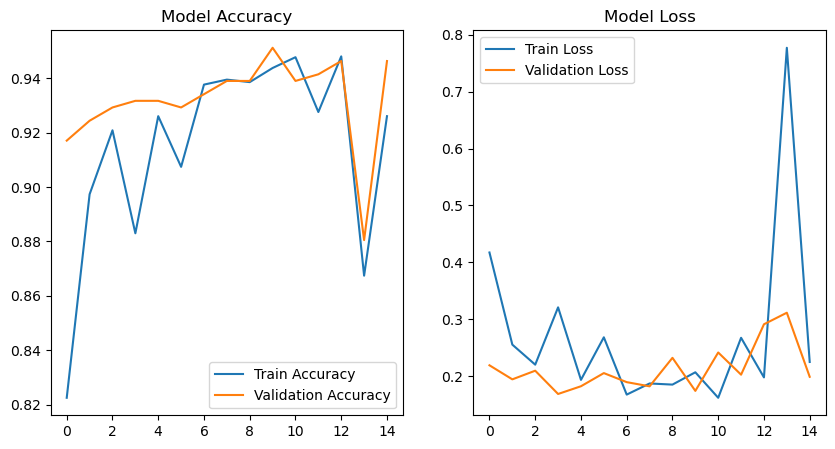

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9563 - loss: 0.2407
Test Accuracy: 0.9633
Model saved successfully!


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# Set seed for reproducibility
import numpy as np
import random
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Set dataset paths
train_dir = "../dataset_split/train"
val_dir = "../dataset_split/val"
test_dir = "../dataset_split/test"

# Image dimensions and batch size
img_size = (128, 128)
batch_size = 64 # Can be adjusted(tried 32/64/96/128) 64 gave the best result


#we can choose to augment the data or not. I got better results without data augmentation

train_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation

#data augmentation
# train_datagen = ImageDataGenerator(
#     rescale=1./255,  
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)

# Only rescale validation and test images (No Augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    #shuffle=False  # Ensure consistency
    #the shuffle parameter determines whether the order of images is randomized when batches are created.
)

# Load validation data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    #shuffle=False 
    #the shuffle parameter determines whether the order of images is randomized when batches are created.
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    #shuffle=False
    #the shuffle parameter determines whether the order of images is randomized when batches are created.
)

# Define the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (with_mask / without_mask)
    #for activation function we tried sigmoid and softmax. Sigmoid gave better results
])

# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Save the initial weights if not already saved
#initial_weights_path = "initial_weights.h5"
initial_weights_path = "initial_weights.weights.h5"#This is done to ensure consistency accrross different runs for the same hyper parameters


if not os.path.exists(initial_weights_path):
    model.save_weights(initial_weights_path)
    print("Initial weights saved.")

# Load initial weights before training to ensure consistency
model.load_weights(initial_weights_path)
print("Initial weights loaded.")

# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15#tried 10/15/20 15 gave the best result
)

# Plot Training Accuracy & Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")

plt.show()

# Evaluate the Model on Test Data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Save the Model
model.save("face_mask_cnn1.keras")
print("Model saved successfully!")


In [64]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("face_mask_cnn1.keras")

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9677 - loss: 0.1613
Test Accuracy: 0.9633


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8.png - with_mask


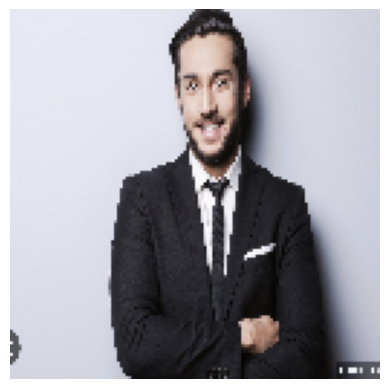

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9.png - without_mask


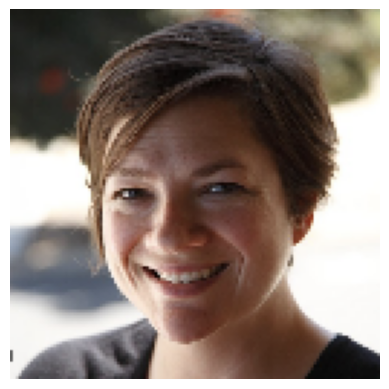

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10.png - without_mask


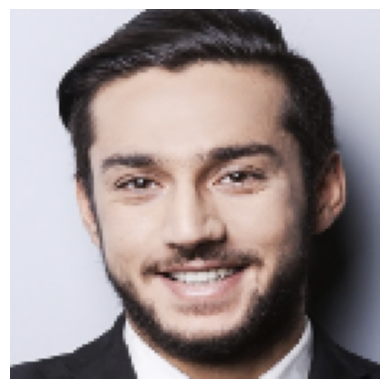

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4.png - with_mask


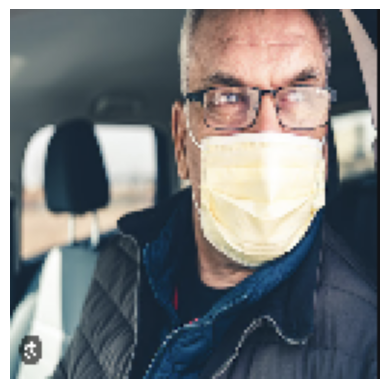

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5.png - with_mask


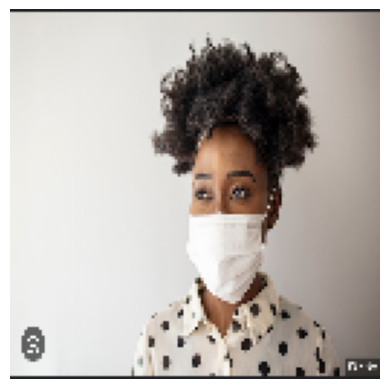

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7.png - with_mask


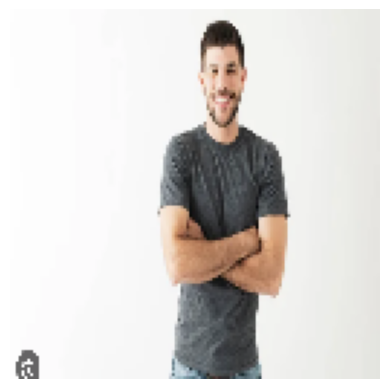

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6.png - with_mask


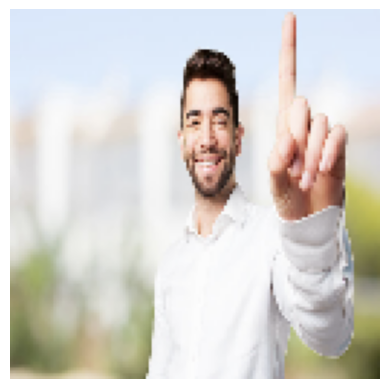

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2.png - with_mask


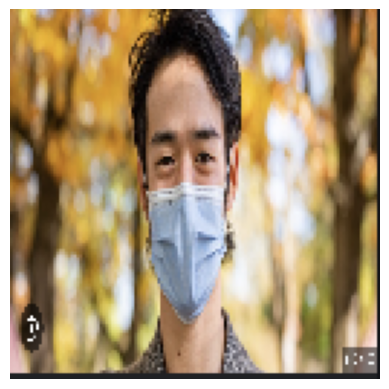

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3.png - with_mask


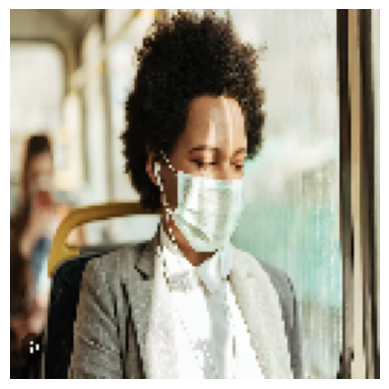

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1.png - with_mask


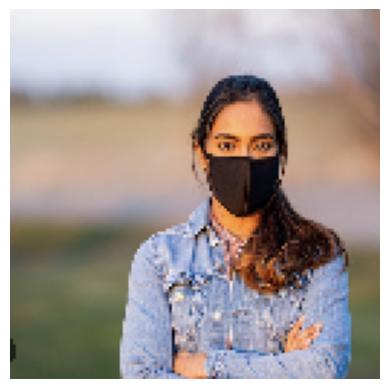

In [68]:
#code to classify the images in photos directory using the trained model face_mask_cnn.h5 and output in the jupyter notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("face_mask_cnn1.keras")

# run the model for all the images in the photos directory
photos_dir = "photos"
for img_name in os.listdir(photos_dir):
    img_path = os.path.join(photos_dir, img_name)
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict the class of the image
    prediction = model.predict(img_array)
    if prediction[0][0] < 0.6:
        print(f"{img_name} - with_mask")
    else:
        print(f"{img_name} - without_mask")

    # Display the image
    plt.imshow(img)
    plt.axis("off")
    plt.show()




#The results below are on external images not from the dataset
#A lot of these images have the full body view of the person and the face is not clearly visible which is from the dataset we wer given
#Thats why the model does not worlk on the first image but gives the right output for the third image
#The model works well on the images where the face is clearly visible

In [71]:
#print the number of images in train/with_mask and train/without_mask
print("Number of images in train/with_mask:", len(os.listdir("dataset_split/train/1")))
print("Number of images in train/without_mask:", len(os.listdir("dataset_split/train/0")))

Number of images in train/with_mask: 1544
Number of images in train/without_mask: 1732


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0_0_anhu_0155.jpg - without_mask


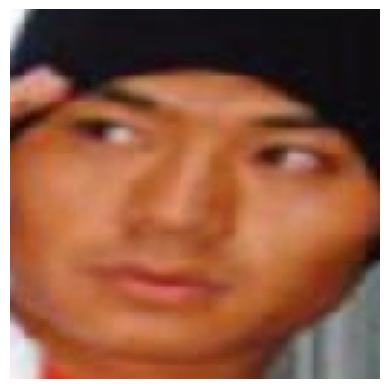

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
0_0_33 copy.jpg - with_mask


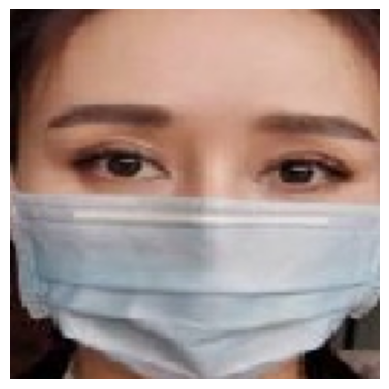

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
58.jpg - with_mask


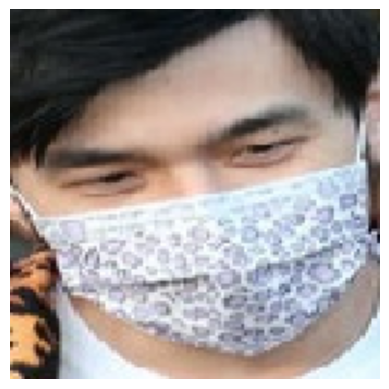

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
with_mask504.jpg - with_mask


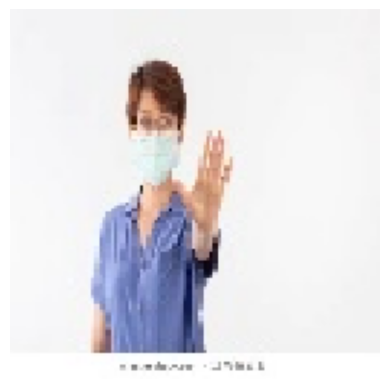

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
261.jpg - without_mask


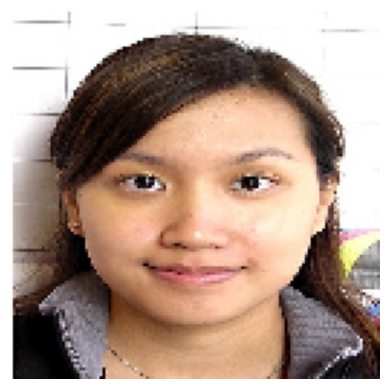

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Screenshot (355).png - with_mask


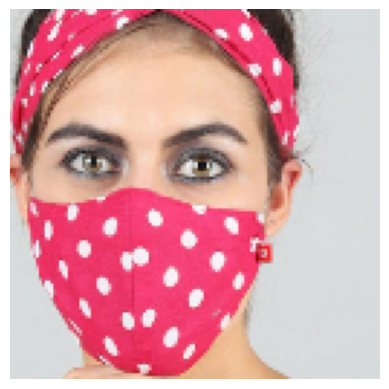

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
478.jpg - without_mask


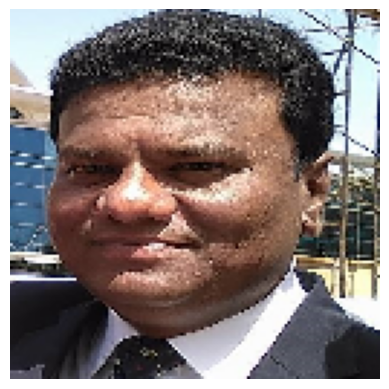

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
yell3.png - with_mask


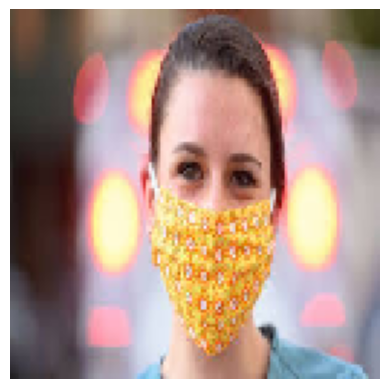

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
124.jpg - without_mask


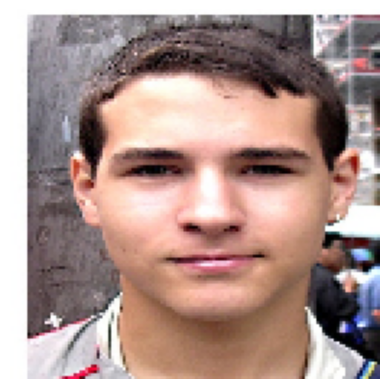

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
augmented_image_175.jpg - without_mask


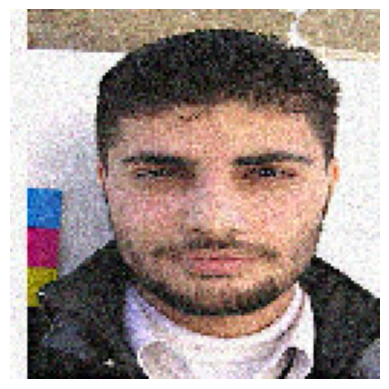

In [73]:
#code to classify the images in photos directory using the trained model face_mask_cnn.h5 and output in the jupyter notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("face_mask_cnn1.keras")

# run the model for all the images in the photos directory
photos_dir = "photos_from_test"
for img_name in os.listdir(photos_dir):
    img_path = os.path.join(photos_dir, img_name)
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict the class of the image
    prediction = model.predict(img_array)
    if prediction[0][0] < 0.6:
        print(f"{img_name} - with_mask")
    else:
        print(f"{img_name} - without_mask")

    # Display the image
    plt.imshow(img)
    plt.axis("off")
    plt.show()

#The images below are from the test dataset
#The model works well on the images where the face is clearly visible